## Linear Model Selection and Regularization

In the regression settings, the standard linear model is commonly used to describe the relationship between a response $Y$ and a set of variables $X_1,X_2,\ldots, X_p$. 

Howevee, the linear model **has distinct advantages** in terms of inference and, on real-world problems, is often surpringly competitive in relation to non-linear models.

It is often surprisingly competitive to non-linear methods.

By replacing "plain least squares fitting" with some alternative fitting procedures can yield better prediction accuracy and model interpretability

### Prediction accuracy

### Model interpretability

There are many alternatives, both classical and modern, to using least squares to fit the models of interest. Now we discuss three important classes of methods.

### Subset selection

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import itertools
from IPython.display import display, HTML
from sklearn import linear_model
from sklearn.model_selection import KFold
from ipywidgets import interact
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')

In [157]:
data = pd.read_excel('macro.xls', index_col=0)
data.head()

,MICROSOFT,SANDP,CPI,INDPRO,M1SUPPLY,CCREDIT,BMINUSA,USTB3M,USTB10Y
Date,,,,,,,,,
1986-03-01,0.095486,238.899994,108.8,56.5414,624.3,606.7990,1.50,6.76,7.78
1986-04-01,0.111979,235.520004,108.6,56.5654,647.0,614.3669,1.40,6.24,7.30
1986-05-01,0.121528,247.350006,108.9,56.6850,645.7,621.9152,1.20,6.33,7.71
1986-06-01,0.106771,250.839996,109.5,56.4959,662.8,627.8910,1.21,6.40,7.80
1986-07-01,0.098958,236.119995,109.5,56.8096,673.4,633.6083,1.28,6.00,7.30


In [158]:
def LogDiff(x):
    x_diff = 100*np.log(x/x.shift(1))
    x_diff = x_diff.dropna()
    return x_diff

In [159]:
data = pd.DataFrame({'dspread' : data['BMINUSA'] - \
data['BMINUSA'].shift(1),
'dcredit' : data['CCREDIT'] - \
data['CCREDIT'].shift(1),
'dprod' : data['INDPRO'] - \
data['INDPRO'].shift(1),
'rmsoft' : LogDiff(data['MICROSOFT']),
'rsandp' : LogDiff(data['SANDP']),
'dmoney' : data['M1SUPPLY'] - \
data['M1SUPPLY'].shift(1),
'inflation' : LogDiff(data['CPI']),
'term' : data['USTB10Y'] - data['USTB3M'],
'dinflation' : LogDiff(data['CPI']) - \
LogDiff(data['CPI']).shift(1),
'mustb3m' : data['USTB3M']/12,
'rterm' : (data['USTB10Y'] - data['USTB3M']) - \
(data['USTB10Y'] - data['USTB3M']).shift(1),
'ermsoft' : LogDiff(data['MICROSOFT']) - \
data['USTB3M']/12,
'ersandp' : LogDiff(data['SANDP']) - \
data['USTB3M']/12})

In [160]:
data.head()

,dspread,dcredit,dprod,rmsoft,rsandp,dmoney,inflation,term,dinflation,mustb3m,rterm,ermsoft,ersandp
Date,,,,,,,,,,,,,
1986-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.02,NaN,0.563333,NaN,NaN,NaN
1986-04-01,-0.10,7.5679,0.0240,15.933171,-1.424918,22.7,-0.183993,1.06,NaN,0.520000,0.04,15.413171,-1.944918
1986-05-01,-0.20,7.5483,0.1196,8.183334,4.900851,-1.3,0.275862,1.38,0.459855,0.527500,0.32,7.655834,4.373351
1986-06-01,0.01,5.9758,-0.1891,-12.945833,1.401091,17.1,0.549452,1.40,0.273590,0.533333,0.02,-13.479167,0.867757
1986-07-01,0.07,5.7173,0.3137,-7.599084,-6.047514,10.6,0.000000,1.30,-0.549452,0.500000,-0.10,-8.099084,-6.547514


Perform best subset selection by identifying the best model that contains a given number of predictors, where best is quantified using RSS.

In [161]:
def get_models(k, X, y):
    """
    Fit all possible models that contain exactly k predictors.
    """
    # List all available predictors
    X_combos = itertools.combinations(list(X.columns), k)
    
    # Fit all models accumulating Residual Sum of Squares (RSS)
    models = []
    for X_label in X_combos:
        # Parse patsy formula
        X_smf = ' + '.join(X_label)
        f     = 'ermsoft ~ {}'.format(X_smf)
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        # Return results
        models += [(f, model)]
    return models


def min_rss(statsmodels):
    """Return model with lowest Residual Sum of Squares (RSS)"""
    return sorted(statsmodels, key=lambda tup: tup[1].ssr)[0]


def max_adjr2(statsmodels):
    """Return model with lowest R-squared"""
    return sorted(statsmodels, reverse=True, key=lambda tup: tup[1].rsquared_adj)[0]


Which model with 2 predictors yields lowest RSS score?

In [162]:
X = data.drop(data[['ermsoft', "rmsoft", "rsandp", "inflation", "term"]], axis=1)
y = data['ermsoft']

# Set number ofr predictors in subset
k = 3

# Get all possible models in subset
subset = get_models(3, X, y)

# Display results
print('This model yields the lowest RSS score for the subset of models with {} predictors:'.format(k))
display(min_rss(subset))

print('This model yields the highest adjusted R-squared score for the subset of models with {} predictors:'.format(k))
max_adjr2(get_models(3, X, y))

This model yields the lowest RSS score for the subset of models with 3 predictors:


('ermsoft ~ dinflation + rterm + ersandp',
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x143ec1d57c0>)

This model yields the highest adjusted R-squared score for the subset of models with 3 predictors:


('ermsoft ~ dinflation + rterm + ersandp',
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x143ebfd3a90>)

In [92]:
X.columns

Index(['dspread', 'dcredit', 'dprod', 'dmoney', 'dinflation', 'mustb3m',
       'rterm', 'ersandp'],
      dtype='object')

The model with 2 predictors that yields the lowest RSS score is the one that uses the predictors 'rterm', and 'ersandp'

### How do the the maximum $R^2$, minimum RSS, and BIC statistics vary for each subset with k predictors? 

First we fit all possible models in each subset of models with k predictors. This turns out to be a very computationally expensive process, running on my laptop for XX minutes yielded results up to only k=6 and occupied XXGB of memeory. Not suprising as number of possible combinations without repetition is given by:

$\frac{p!}{k!(p-k)!}$

Where *p* is number of predictors to choose from and we choose *k* of them.

In this example p=8, there are 8 predictors.

For k = 6 the number of possible combinations is given by:

$\frac{8!}{2!x 6!} = 28$

In [166]:
40320/(2*720)

28.0

In [163]:
import math
num = input("Enter a number: ")
print("The factorial of ", num, " is : ")
print(math.factorial(int(num)))

Enter a number: 8
The factorial of  8  is : 
40320


In [165]:
import math
num = input("Enter a number: ")
print("The factorial of ", num, " is : ")
print(math.factorial(int(num)))

Enter a number: 6
The factorial of  6  is : 
720


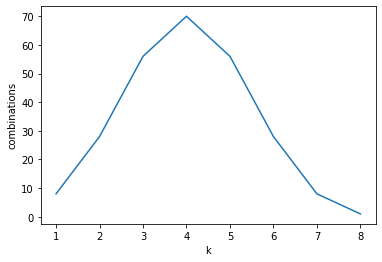

In [168]:
# How does the number of possible combinations of the 8 features vary with k?
# Lets do a quick plot to find out!

from scipy.special import factorial

n = 8
k = np.arange(1, n+1)
y = factorial(n) / (factorial(k)*factorial(n-k))

ax = sns.lineplot(x=k, y=y)
plt.xlabel('k')
plt.ylabel('combinations');

The plot above shows that there up to ~70 possible combinations of the predictors without repetition for some values of k when p = 8

The objective is provide comparison of the $R^2$ statistic for all combinations of 8 predictors.

In [169]:
# Pick subset of predictors 
X = data.drop(data[['ermsoft', "rmsoft", "rsandp", "inflation", "term"]], axis=1)
y = data['ermsoft']

In [170]:
# get all model results
model_subsets = []
for k in range(len(X.columns)):
    k=k+1
    subset = get_models(k, X, y)
    model_subsets += [subset]
    print('Progess: k = {}, done'.format(k))

Progess: k = 1, done
Progess: k = 2, done
Progess: k = 3, done
Progess: k = 4, done
Progess: k = 5, done
Progess: k = 6, done
Progess: k = 7, done
Progess: k = 8, done


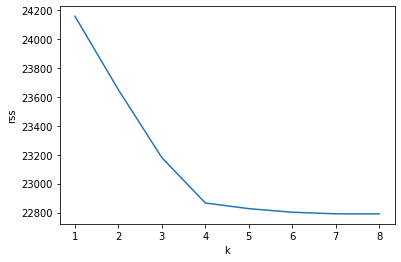

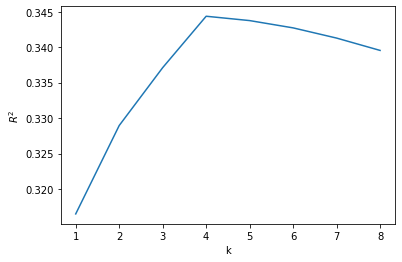

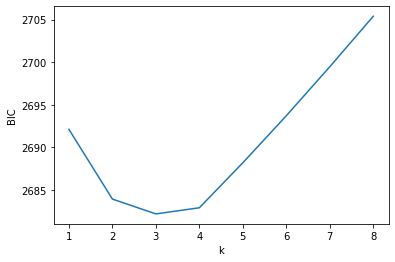

In [171]:
# Get best rss score for each subset
rss   = [min_rss(m)[1].ssr for m in model_subsets]

# Get best r-squared score for each subset
adjr2 = [max_adjr2(m)[1].rsquared_adj for m in model_subsets]
k     = np.arange(1, len(rss)+1)


# Get best BIC
def min_bic(statsmodels):
    """Return model with lowest R-squared"""
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].bic)[0]

bic = [min_bic(m)[1].bic for m in model_subsets]


ax = sns.lineplot(x=k, y=rss)
plt.xlabel('k')
plt.ylabel('rss')
plt.show()

sns.lineplot(x=k, y=adjr2)
plt.xlabel('k')
plt.ylabel('$R^2$')
plt.show()

sns.lineplot(x=k, y=bic)
plt.xlabel('k')
plt.ylabel('BIC')
plt.show()

The stats above seem to confer that a model with around 4 predictors is best. But has each method chosen the same or similar models?

In [172]:
best_subset_4 = list(min_rss(model_subsets[3])[1].params.index)[1:]
print(best_subset_4)

['dinflation', 'mustb3m', 'rterm', 'ersandp']


In [97]:
list(max_adjr2(model_subsets[3])[1].params.index)[1:]

['dinflation', 'mustb3m', 'rterm', 'ersandp']

In [98]:
list(min_bic(model_subsets[3])[1].params.index)[1:]

['dinflation', 'mustb3m', 'rterm', 'ersandp']

All three statisticis yield the same model for the subset with 4 predictors. This is expected for RSS and R-squared stats because they are related.

### Forward and Backward Stepwise Selection

In [176]:
def scale(df):
    """Xi = Xi - mu(Xi) / σ(Xi)"""
    return (df-df.mean())/(df.std())


def forward_stepwise(X, y, results=[(0, [])]):
    """Perform forward stepwise variable selection as described in
    An Introductions to Statistical Learning (p.207)
    Returns pandas dataframe object  with results for each step"""
    # List predictors that havent's been used so far
    p_all    = list(X.columns)
    p_used   = results[-1][1]
    p_unused = [p for p in p_all if p not in p_used]
    
    # Job done, exit recursion
    if not p_unused:
        rss   = [r[0] for r in results]
        preds = [r[1] for r in results]
        return pd.DataFrame({'rss': rss, 'predictors': preds}).drop(0).reset_index()
    
    # Get rss score for each possible additional predictor
    r = []
    for p in p_unused:
        f     = 'ermsoft ~ {}'.format('+'.join([p]+p_used))
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        r     += [(model.ssr, [p]+p_used)]
    
    # Choose predictor which yields lowest rss
    min_rss     = sorted(r, key=lambda tup: tup[0])[0]   
    new_results = results + [min_rss]
    # Recursive call to self
    return forward_stepwise(X, y, new_results)


def backward_stepwise(X, y, results=[]):
    """Returns pandas dataframe object  with results for each step"""
    # List predictors that havent's been used so far
    p_all    = list(X.columns)

    # Check if we're starting out here
    if not results:
        # Fit model with all features
        f     = 'ermsoft ~ {}'.format('+'.join(p_all))
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        # Begin backward stepwise recursion
        return backward_stepwise(X, y, [(model.ssr, p_all)])
    else:
        p_used = results[-1][1]
    
    # Job done, exit recursion
    if len(p_used) == 1:
        rss   = [r[0] for r in results]
        preds = [r[1] for r in results]
        return pd.DataFrame({'rss': rss, 'predictors': preds})    
    
    # Get rss score for each possible removed predictor
    r = []
    for p in p_used:
        p_test = [i for i in p_used if i != p]
        f     = 'ermsoft ~ {}'.format('+'.join(p_test))
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        r     += [(model.ssr, p_test)]
    
    # Choose removal of predictor which yields lowest rss
    min_rss     = sorted(r, key=lambda tup: tup[0])[0]   
    new_results = results + [min_rss]
    return backward_stepwise(X, y, new_results)

In [177]:
X = scale(X)

forward_stepwise_results = forward_stepwise(X, y)
display(HTML('<h4>Forward Stepwise Selection</h4>'))
display(forward_stepwise_results)

backward_stepwise_results = backward_stepwise(X, y)
display(HTML('<h4>Backward Stepwise Selection</h4>'))
display(backward_stepwise_results)

,index,rss,predictors
0,1,24159.704476,[ersandp]
1,2,23650.388354,"[dinflation, ersandp]"
2,3,23179.991633,"[rterm, dinflation, ersandp]"
3,4,22865.956746,"[mustb3m, rterm, dinflation, ersandp]"
4,5,22826.772983,"[dcredit, mustb3m, rterm, dinflation, ersandp]"
5,6,22801.910896,"[dprod, dcredit, mustb3m, rterm, dinflation, e..."
6,7,22791.048493,"[dspread, dprod, dcredit, mustb3m, rterm, dinf..."
7,8,22790.323273,"[dmoney, dspread, dprod, dcredit, mustb3m, rte..."


,rss,predictors
0,22790.323273,"[dspread, dcredit, dprod, dmoney, dinflation, ..."
1,22791.048493,"[dspread, dcredit, dprod, dinflation, mustb3m,..."
2,22801.910896,"[dcredit, dprod, dinflation, mustb3m, rterm, e..."
3,22826.772983,"[dcredit, dinflation, mustb3m, rterm, ersandp]"
4,22865.956746,"[dinflation, mustb3m, rterm, ersandp]"
5,23179.991633,"[dinflation, rterm, ersandp]"
6,23650.388354,"[dinflation, ersandp]"
7,24159.704476,[ersandp]


In [179]:
display(HTML('<h4>Comparison of methods for subset with 4 predictors</h4>'))
print('Best Subset Selection       : {}'.format(sorted(best_subset_4)))
print('Forward Stepwise Selection  : {}'.format(sorted(forward_stepwise_results.loc[3]['predictors'])))
print('Backward Stepwise Selection : {}'.format(sorted(backward_stepwise_results.loc[4]['predictors'])))

Best Subset Selection       : ['dinflation', 'ersandp', 'mustb3m', 'rterm']
Forward Stepwise Selection  : ['dinflation', 'ersandp', 'mustb3m', 'rterm']
Backward Stepwise Selection : ['dinflation', 'ersandp', 'mustb3m', 'rterm']


The above results show that all three methods choose the same 4 predictors.

### Choosing Among Models Using the Validation Set Approach and Cross-Validation

In [180]:
def best_subset_rss(X, y):
    """Perform best subset selection using Residual Sum of Squares to
    select best model in each subset.
    Notes: highly computationally expensive for large number of features in  X
    Maxes out my laptop for p > 14"""
    # get all model results
    model_subsets = []
    for k in range(len(X.columns)):
        k=k+1
        subset = get_models(k, X, y)
        model_subsets += [subset]
        print('Best subset selected: k = {}/{}, done'.format(k, len(X.columns)))
    # Get best rss score for each subset
    return [min_rss(m) for m in model_subsets]

def mse(y_hat, y):
    """Calculate Mean Squared Error"""
    return np.sum(np.square(y_hat - y)) / y.size

In [181]:
# Create index for 50% holdout set
np.random.seed(1)
train = np.random.rand(len(data)) < 0.5

response   = 'ermsoft'

# Assign train and test sets
X_train = data[train][['dspread', 'dcredit', 'dprod', 'dmoney','dinflation', 'mustb3m', 'rterm', 'ersandp']]
X_test  = data[~train][['dspread', 'dcredit', 'dprod', 'dmoney','dinflation', 'mustb3m', 'rterm', 'ersandp']]
y_train = data[train][response]
y_test  = data[~train][response]

In [182]:
# Perform best_subset selection
best_subsets = best_subset_rss(X_train, y_train)

Best subset selected: k = 1/8, done
Best subset selected: k = 2/8, done
Best subset selected: k = 3/8, done
Best subset selected: k = 4/8, done
Best subset selected: k = 5/8, done
Best subset selected: k = 6/8, done
Best subset selected: k = 7/8, done
Best subset selected: k = 8/8, done


,predictors,MSE
0,1,63.729048
1,2,63.302836
2,3,62.143353
3,4,62.119221
4,5,62.434003
5,6,63.096877
6,7,61.449342
7,8,61.468369


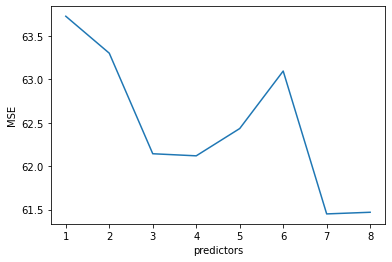

In [103]:
# Using 50% hold out set
# Measure mean squared error for each model selected by best subset selection
MSEs = []
for m in best_subsets:
    model = m[1]
    y_hat = model.predict(X_test)
    r     = mse(y_hat, y_test)
    MSEs += [r]

results = pd.DataFrame({'predictors': np.arange(1, 9), 'MSE': MSEs})
display(results)
sns.lineplot(x='predictors', y='MSE', data=results);

Above we performed best subset selection up to 10 predictors using the training set createad from a 50% hold-out set. We then use the test set to measure the MSE for the selected model in each subset of p predictors. 

We observe the lowest MSE for the model with 7 predictors.

In [183]:
# Which 7 predictors did best subset selection choose based on the TRAINING set?
best_subsets[6][0]

'ermsoft ~ dspread + dcredit + dprod + dinflation + mustb3m + rterm + ersandp'

In [184]:
# Which 7 predictors does best subset selection choose based on the FULL set?
best_subsets_full = best_subset_rss(data[['dspread', 'dcredit', 'dprod', 'dmoney','dinflation', 'mustb3m', 'rterm', 'ersandp']], data['ermsoft'])
best_subsets_full[6][0]

Best subset selected: k = 1/8, done
Best subset selected: k = 2/8, done
Best subset selected: k = 3/8, done
Best subset selected: k = 4/8, done
Best subset selected: k = 5/8, done
Best subset selected: k = 6/8, done
Best subset selected: k = 7/8, done
Best subset selected: k = 8/8, done


'ermsoft ~ dspread + dcredit + dprod + dinflation + mustb3m + rterm + ersandp'

Both models are the same.

In [185]:
def cross_val(formula, X, y, k):
    """Perform k-fold cross validation to return mean MSE score
    Expects formula as Patsy formula"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = smf.ols(formula=formula, data=pd.concat([X_train, y_train], axis=1)).fit()
        
        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test)]
    return (MSEs, formula)

In [186]:
# Get best subsets of predictors for full dataset

best_subsets_full = best_subset_rss(X, y)

Best subset selected: k = 1/8, done
Best subset selected: k = 2/8, done
Best subset selected: k = 3/8, done
Best subset selected: k = 4/8, done
Best subset selected: k = 5/8, done
Best subset selected: k = 6/8, done
Best subset selected: k = 7/8, done
Best subset selected: k = 8/8, done


In [187]:
# Perform cross validation for each subset of predictors
results = []
for sub in best_subsets_full:
    results += [cross_val(sub[0], X, y, 10)]

results_a_df = pd.DataFrame({'predictors': list(np.arange(1, 9)),
                           'MSE_mean': [np.mean(i[0]) for i in results],
                           'MSE_folds': [i[0] for i in results],
                           'Model': [i[1] for i in results]})
display(results_a_df)


,predictors,MSE_mean,MSE_folds,Model
0,1,63.717523,"[134.65920106142354, 76.97286126016476, 53.285...",ermsoft ~ ersandp
1,2,62.898537,"[126.3899281554123, 74.42090716147204, 52.5294...",ermsoft ~ dinflation + ersandp
2,3,62.200584,"[123.47000528573811, 70.02566006778459, 51.954...",ermsoft ~ dinflation + rterm + ersandp
3,4,61.502725,"[122.57229995063736, 65.28271959572727, 51.526...",ermsoft ~ dinflation + mustb3m + rterm + ersandp
4,5,61.496333,"[122.12426131822511, 64.69163375900831, 51.227...",ermsoft ~ dcredit + dinflation + mustb3m + rte...
5,6,61.564914,"[122.37276679405389, 64.41763542420439, 51.463...",ermsoft ~ dcredit + dprod + dinflation + mustb...
6,7,61.579962,"[122.30690300176789, 64.28844254764996, 51.522...",ermsoft ~ dspread + dcredit + dprod + dinflati...
7,8,61.608220,"[122.3375290511312, 64.3746238201491, 51.55009...",ermsoft ~ dspread + dcredit + dprod + dmoney +...


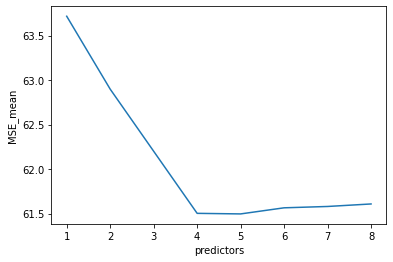

In [111]:
sns.lineplot(x='predictors', y='MSE_mean', data=results_a_df);

In [188]:
best_subset_choice = results_a_df[results_a_df['MSE_mean'] == results_a_df['MSE_mean'].min()]
display(best_subset_choice)

best_subset_choice['Model'].iloc[0]

,predictors,MSE_mean,MSE_folds,Model
4,5,61.496333,"[122.12426131822511, 64.69163375900831, 51.227...",ermsoft ~ dcredit + dinflation + mustb3m + rte...


'ermsoft ~ dcredit + dinflation + mustb3m + rterm + ersandp'

We see that 10-fold cross validation selects an 5 variable model. The estimated test MSE is 61.49.

### Can we get a better model by Backwards Stepwise on all features?

,rss,predictors,predictor_count
0,22790.323273,"[dspread, dcredit, dprod, dmoney, dinflation, ...",1
1,22791.048493,"[dspread, dcredit, dprod, dinflation, mustb3m,...",2
2,22801.910896,"[dcredit, dprod, dinflation, mustb3m, rterm, e...",3
3,22826.772983,"[dcredit, dinflation, mustb3m, rterm, ersandp]",4
4,22865.956746,"[dinflation, mustb3m, rterm, ersandp]",5
5,23179.991633,"[dinflation, rterm, ersandp]",6
6,23650.388354,"[dinflation, ersandp]",7
7,24159.704476,[ersandp],8


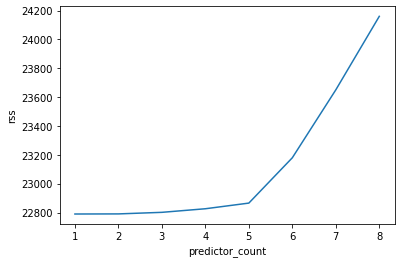

In [189]:
backward_stepwise_subsets = backward_stepwise(X, y)
backward_stepwise_subsets['predictor_count'] = np.arange(1, 9)
display(backward_stepwise_subsets)

sns.lineplot(x='predictor_count', y='rss', data=backward_stepwise_subsets);

In [190]:
# Perform cross validation for each subset of predictors
results = []
for preds in backward_stepwise_subsets['predictors']:
    f = 'ermsoft ~ {}'.format(' + '.join(preds))
    results += [cross_val(f, X, y, 10)]

results_b_df = pd.DataFrame({'predictors': list(np.arange(1, len(results)+1)),
                           'MSE_mean': [np.mean(i[0]) for i in results],
                           'MSE_folds': [i[0] for i in results],
                           'Model': [i[1] for i in results]})
display(results_b_df)


,predictors,MSE_mean,MSE_folds,Model
0,1,61.608220,"[122.3375290511312, 64.3746238201491, 51.55009...",ermsoft ~ dspread + dcredit + dprod + dmoney +...
1,2,61.579962,"[122.30690300176789, 64.28844254764996, 51.522...",ermsoft ~ dspread + dcredit + dprod + dinflati...
2,3,61.564914,"[122.37276679405389, 64.41763542420439, 51.463...",ermsoft ~ dcredit + dprod + dinflation + mustb...
3,4,61.496333,"[122.12426131822511, 64.69163375900831, 51.227...",ermsoft ~ dcredit + dinflation + mustb3m + rte...
4,5,61.502725,"[122.57229995063736, 65.28271959572727, 51.526...",ermsoft ~ dinflation + mustb3m + rterm + ersandp
5,6,62.200584,"[123.47000528573811, 70.02566006778459, 51.954...",ermsoft ~ dinflation + rterm + ersandp
6,7,62.898537,"[126.3899281554123, 74.42090716147204, 52.5294...",ermsoft ~ dinflation + ersandp
7,8,63.717523,"[134.65920106142354, 76.97286126016476, 53.285...",ermsoft ~ ersandp


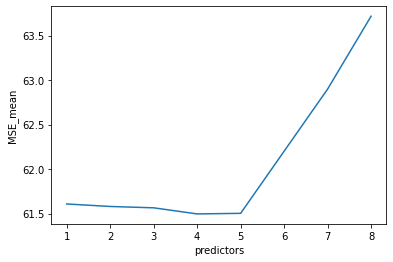

In [120]:
sns.lineplot(x='predictors', y='MSE_mean', data=results_b_df);

In [191]:
display(HTML('</br><h4>Best Subset Selection from 10 predictors, with 10-fold Cross Validation</h4>'))
best_subset_choice = results_a_df[results_a_df['MSE_mean'] == results_a_df['MSE_mean'].min()]
display(best_subset_choice)
print(best_subset_choice['Model'].iloc[0])

display(HTML('</br><h4>Backward Stepwise Selection from all 10 predictors, with 10-fold Cross Validation</h4>'))
backward_select_choice = results_b_df[results_b_df['MSE_mean'] == results_b_df['MSE_mean'].min()]
display(backward_select_choice)
print(backward_select_choice['Model'].iloc[0])

,predictors,MSE_mean,MSE_folds,Model
4,5,61.496333,"[122.12426131822511, 64.69163375900831, 51.227...",ermsoft ~ dcredit + dinflation + mustb3m + rte...


ermsoft ~ dcredit + dinflation + mustb3m + rterm + ersandp


,predictors,MSE_mean,MSE_folds,Model
3,4,61.496333,"[122.12426131822511, 64.69163375900831, 51.227...",ermsoft ~ dcredit + dinflation + mustb3m + rte...


ermsoft ~ dcredit + dinflation + mustb3m + rterm + ersandp


### Shrinkage

## Ridge Regression and the Lasso

### Ridge Regression

Let's perform ridge regression with 10-fold cross-validation to produce results comparable to those obtained for model selection approaches above.

In [192]:
def ridge_cv(X, y, λ, k):
    """Perform ridge regresion with 
    k-fold cross validation to return mean MSE scores for each fold"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = linear_model.Ridge(alpha=λ, fit_intercept=False, solver='cholesky').fit(X_train, y_train)
        
        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test)]
    return MSEs

In [193]:
X.dropna(inplace=True)

In [194]:
data.dropna(inplace=True)

In [195]:
data.shape

(383, 13)

In [196]:
data.head()

,dspread,dcredit,dprod,rmsoft,rsandp,dmoney,inflation,term,dinflation,mustb3m,rterm,ermsoft,ersandp
Date,,,,,,,,,,,,,
1986-05-01,-0.20,7.5483,0.1196,8.183334,4.900851,-1.3,0.275862,1.38,0.459855,0.527500,0.32,7.655834,4.373351
1986-06-01,0.01,5.9758,-0.1891,-12.945833,1.401091,17.1,0.549452,1.40,0.273590,0.533333,0.02,-13.479167,0.867757
1986-07-01,0.07,5.7173,0.3137,-7.599084,-6.047514,10.6,0.000000,1.30,-0.549452,0.500000,-0.10,-8.099084,-6.547514
1986-08-01,0.18,6.9043,-0.0748,0.000000,6.877261,5.0,0.182482,1.48,0.182482,0.474167,0.18,-0.474167,6.403095
1986-09-01,-0.15,9.3754,0.1135,-0.881009,-8.931068,6.1,0.454753,2.10,0.272271,0.445833,0.62,-1.326843,-9.376901


In [197]:
X = data.drop(data[['ermsoft', "rmsoft", "rsandp", "inflation", "term"]], axis=1)
y = data['ermsoft']

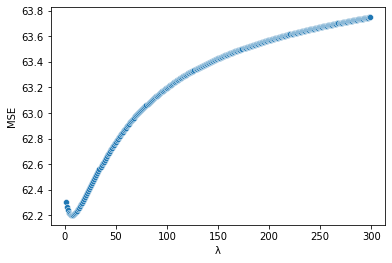

In [198]:
#lambdas = np.arange(0, 0.08, 0.0005)
lambdas = np.arange(1, 300, 1)
MSEs    = [] 
for l in lambdas:
    MSEs += [np.mean(ridge_cv(X, y, λ=l, k=10))]

sns.scatterplot(x='λ', y='MSE', data=pd.DataFrame({'λ': lambdas, 'MSE': MSEs}));

In [199]:
min(zip(MSEs, lambdas))

(62.20300220778345, 7)

Here we use 10-fold cross-validation to find the optimal value for lambda. The lowest MSE score achieved is 62,20 when λ=7.

**Revision note:** This result is worst than our results for backward stepwise selection and best subset.


(array([-1.,  0.,  1.,  2.,  3.,  4.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

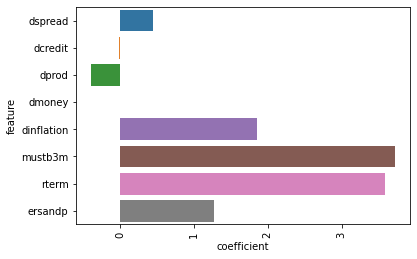

In [200]:
# What coefficients does ridge regression choose for the optimal lambda value?
model = linear_model.Ridge(alpha=7, fit_intercept=False, solver='cholesky').fit(X, y)
df = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_})
ax = sns.barplot(x='coefficient', y='feature', data=df);
plt.xticks(rotation=90)

### The Lasso

In [201]:
def lasso_cv(X, y, λ, k):
    """Perform the lasso with 
    k-fold cross validation to return mean MSE scores for each fold"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = linear_model.Lasso(alpha=λ, copy_X=True, fit_intercept=False, max_iter=10000,
                                   normalize=False, positive=False, precompute=False, random_state=None,
                                   selection='cyclic', tol=0.0001, warm_start=False).fit(X_train, y_train)
        
        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test)]
    return MSEs

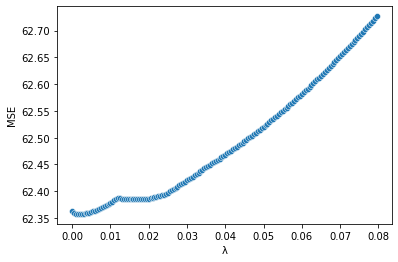

In [137]:
X = data.drop(data[['ermsoft', "rmsoft", "rsandp", "inflation", "term"]], axis=1)
y = data['ermsoft']

#lambdas = np.arange(0, 0.08, 0.0005)

lambdas = np.arange(0, 0.08, 0.0005)
MSEs    = [] 
for l in lambdas:
    MSEs += [np.mean(lasso_cv(X, y, λ=l, k=10))]

sns.scatterplot(x='λ', y='MSE', data=pd.DataFrame({'λ': lambdas, 'MSE': MSEs}));

In [138]:
min(zip(MSEs, lambdas))

(62.357690956527065, 0.002)

Here we use 10-fold cross-validation to find the optimal lambda value for the lasso. The lowest MSE score achieved is 62.35 when λ=0.002.

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

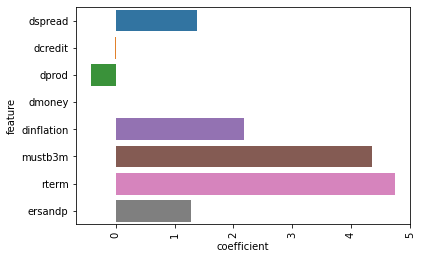

In [202]:
# What coefficients does the lasso choose for the optimal lambda value?
model = linear_model.Lasso(alpha=0.002, copy_X=True, fit_intercept=False, max_iter=10000,
                           normalize=False, positive=False, precompute=False, random_state=None,
                           selection='cyclic', tol=0.0001, warm_start=False).fit(X, y)
df = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_})
ax = sns.barplot(x='coefficient', y='feature', data=df);
plt.xticks(rotation=90)

In [203]:
display(HTML('<h4>Model chosen by lasso:</h4>'))
print('Salary ~ {}'.format(' + '.join(X.columns[model.coef_ != 0])))
print('MSE: {:01.0f}'.format(min(MSEs)))

display(HTML('<h4>Model chosen by backward stepwise selection:</h4>'))
print(backward_select_choice['Model'].iloc[0])
print('MSE: {:01.0f}'.format(backward_select_choice['MSE_mean'].iloc[0]))

Salary ~ dspread + dcredit + dprod + dmoney + dinflation + mustb3m + rterm + ersandp
MSE: 62


ermsoft ~ dcredit + dinflation + mustb3m + rterm + ersandp
MSE: 61


The results here suggesat that backward stepwise finds as simpler model thato utperforms lasso and ridge regression. 

### Dimension reduction

#### PCR and PLS Regression

##### Principle Components Regression

In [142]:
# Deps for pca/pcr
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

In [204]:
X = data.drop(data[['ermsoft', "rmsoft", "rsandp", "inflation", "term"]], axis=1)
y = data['ermsoft']

#### PCA

What percentage of total variance in our dataset is ecplained by succesive accumulation of principal components?

Get all principal components of the predictors in X, using principal component analysis (PCA)

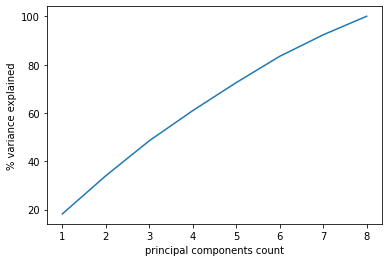

In [205]:
# Get principle components
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

# What variance (%c umulative) is explained by principle components?
variance_explained   = np.cumsum(np.around(pca.explained_variance_ratio_ *100, decimals=1))
principal_components = np.arange(1, len(variance_explained)+1)

sns.lineplot(x='principal components count', y='% variance explained', 
             data=pd.DataFrame({'principal components count': principal_components, 
                                '% variance explained': variance_explained}));

In [206]:
X_reduced = pca.fit_transform(scale(X))
X_reduced.shape

(383, 8)

#### PCR 

How does linear regression perform when these principle components are used as predictors?

In [207]:
def pcr_cv(seed, cv_folds):
    """Perform Principle Component Regression evaluated with
    k-fold cross validation"""
    # Load data
    X = data.drop(data[['ermsoft', "rmsoft", "rsandp", "inflation", "term"]], axis=1)
    y = data['ermsoft']
    
    # Get all principle components
    pca = PCA()
    X_reduced = pca.fit_transform(scale(X))
    
    # Get cv MSE for cumulative components
    M = X_reduced.shape[1]
    MSEs = []
    for m in range(M):
        model = LinearRegression()
        cv    = KFold(n_splits=cv_folds, random_state=seed, shuffle=True)
        cv10  = cross_val_score(model, X_reduced[:, 0:m+1], y, cv=cv, scoring='neg_mean_squared_error')
        MSEs += [np.mean(np.abs(cv10))]
        
    ax = sns.lineplot(x='principal components count', y='MSE', 
                 data=pd.DataFrame({'principal components count': principal_components, 
                                    'MSE': MSEs}));
    ax.axes.set_ylim(10, 100)


interact(pcr_cv, 
         seed=widgets.IntSlider(min=1, max=50, step=1, value=10), 
         cv_folds=widgets.IntSlider(min=2, max=100, step=1, value=10));

interactive(children=(IntSlider(value=10, description='seed', max=50, min=1), IntSlider(value=10, description=…

Above I've implemented the same with interactive sliders to control the random seed used to shuffle observations before splitting into cross validation folds, and a seperate control for number of cross validation folds k. 

Interacting with the seed slider we see that there is some significant variability in the results. With 10 folds, most seed values would lead us to conclude the between 8 principal components are optimal, but there are some seed values – such as 8 – that suggest 6-7 components is in fact optimal. This is a significantly different conclusion!

The results seem to have higher variance when cv_folds is lower, with variance decreasing as the number of folds increases.

**Revision note:** The above point seems counter to what we learned in ch.5, e.g. we expect LOOCV to exhibit highest variance and lowest bias.

In [209]:
def pcr_holdout(seed):
    """Perform Principle Component Regression evaluated with
    k-fold hold-out set"""
    # With 50% holdout set
    np.random.seed(seed)
    train = np.random.rand(len(data)) < 0.5
    
    pca = PCA()
    X_train = pca.fit_transform(scale(data.drop('ermsoft', axis=1)[train]))
    y_train = data['ermsoft'][train]
    X_test  = pca.fit_transform(scale(data.drop('ermsoft', axis=1)[~train]))
    y_test  = data['ermsoft'][~train]
    
    
    # Get cv MSE for cumulative components
    M = X_reduced.shape[1]
    
    MSEs = []
    for m in range(M):
        model = LinearRegression().fit(X_train[:, 0:m+1], y_train)
        y_hat = model.predict(X_test[:, 0:m+1])
        MSEs += [mse(y_hat, y_test)]
    
    # Plot results
    ax = sns.lineplot(x='principal components count', y='MSE', 
                      data=pd.DataFrame({'principal components count': principal_components, 
                                         'MSE': MSEs}))
    ax.axes.set_ylim(10, 100);

interact(pcr_holdout, seed=widgets.IntSlider(min=1, max=50, step=1, value=10));

interactive(children=(IntSlider(value=10, description='seed', max=50, min=1), Output()), _dom_classes=('widget…